In [1]:
# ! pip install kaggle
# ! mkdir ~/.kaggle
# ! cp kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json

In [2]:
# !kaggle datasets download -d datamunge/sign-language-mnist

 69% 43.0M/62.6M [00:00<00:00, 241MB/s]
100% 62.6M/62.6M [00:00<00:00, 251MB/s]


In [3]:
# !mkdir data
# !unzip sign-language-mnist.zip -d /content/data

Archive:  sign-language-mnist.zip
  inflating: /content/data/amer_sign2.png  
  inflating: /content/data/amer_sign3.png  
  inflating: /content/data/american_sign_language.PNG  
  inflating: /content/data/sign_mnist_test.csv  
  inflating: /content/data/sign_mnist_test/sign_mnist_test.csv  
  inflating: /content/data/sign_mnist_train.csv  
  inflating: /content/data/sign_mnist_train/sign_mnist_train.csv  


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report, multilabel_confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
import seaborn as sns

In [5]:
train = pd.read_csv('./data/sign_mnist_train/sign_mnist_train.csv')
test = pd.read_csv('./data/sign_mnist_test/sign_mnist_test.csv')

In [6]:
train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [7]:
train.isnull()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27450,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
27451,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
27452,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
27453,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [8]:
train.isna().sum()

label       0
pixel1      0
pixel2      0
pixel3      0
pixel4      0
           ..
pixel780    0
pixel781    0
pixel782    0
pixel783    0
pixel784    0
Length: 785, dtype: int64

In [9]:
train_df_original = train.copy()

# Split into training, test and validation sets
val_index = int(train.shape[0]*0.2)

train_df = train_df_original.iloc[val_index:]
val_df = train_df_original.iloc[:val_index]

In [10]:
y = np.array(train_df['label'])
X = np.array(train_df.drop(columns='label'))

In [11]:
X.shape,y.shape

((21964, 784), (21964,))

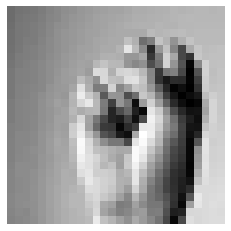

18


In [12]:
import random
r = random.randint(0,(21964-1))
def show_img():
  arr = np.array(X)
  some_value = arr[r]
  some_img = some_value.reshape(28,28)
  plt.imshow(some_img, cmap="gray")
  plt.axis("off")
  plt.show()  

show_img()
print(y[r])

In [13]:
y_train = pd.get_dummies(y)
y_train.head(5)

,0,1,2,3,4,5,6,7,8,10,...,15,16,17,18,19,20,21,22,23,24
0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [14]:
y_val = val_df['label']
X_val = val_df.drop(columns="label",axis=1)

In [15]:
y_val = pd.get_dummies(y_val)

In [16]:
y_train.shape # else it's shape was (21964,)

(21964, 24)

In [17]:
X_val = pd.DataFrame(X_val).values.reshape(X_val.shape[0] ,28, 28, 1)

In [18]:
X_train = pd.DataFrame(X).values.reshape(X.shape[0] ,28, 28, 1)

# reshaping X_train into (27455,28,28,1)

In [19]:
X_train.shape,y_train.shape

((21964, 28, 28, 1), (21964, 24))

In [20]:
# X_train = tf.keras.utils.to_categorical(X_train)
# y_train = tf.keras.utils.to_categorical(y_train)
# X_val = tf.keras.utils.to_categorical(X_val)
# y_val = tf.keras.utils.to_categorical(y_val)

In [21]:
#  Accepts a batch of images used for training.
generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    zoom_range=0.10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=False,
    fill_mode="nearest"
)

X_train_flow = generator.flow(X_train, y_train, batch_size=32)

X_val_flow = generator.flow(X_val, y_val, batch_size=32)

In [22]:
# Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization

model = Sequential()

model.add(Conv2D(filters=32,  kernel_size=(3,3), activation="relu", input_shape=(28,28,1)))
model.add(MaxPool2D((2,2),padding='SAME'))
model.add(Dropout(rate=0.2))


model.add(Conv2D(filters=64,  kernel_size=(3,3), activation="relu", input_shape=(28,28,1)))
model.add(MaxPool2D((2,2),padding='SAME'))
model.add(Dropout(rate=0.2))


model.add(Conv2D(filters=521,  kernel_size=(3,3), activation="relu", input_shape=(28,28,1)))
model.add(MaxPool2D((2,2),padding='SAME'))
model.add(Dropout(rate=0.2))



model.add(Flatten())
model.add(Dense(units=521, activation="relu"))
model.add(Dense(units=256, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(units=24, activation="softmax"))


model.compile(loss="categorical_crossentropy", optimizer='adam',  metrics=["accuracy"])

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 13, 13, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 6, 6, 64)          0

In [24]:
learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001
)

In [25]:
history = model.fit(
    X_train_flow,
    validation_data=X_val_flow,
    # epochs=100,
    epochs=50,
    callbacks=[
               tf.keras.callbacks.EarlyStopping(
                   monitor='val_loss',
                   patience=5,
                   restore_best_weights=True
                   ),
      learning_rate_reduction
    ])

Epoch 1/50
687/687 [==============================] - 14s 19ms/step - loss: 2.3559 - accuracy: 0.2566 - val_loss: 0.9714 - val_accuracy: 0.6678 - lr: 0.0010
Epoch 2/50
687/687 [==============================] - 13s 19ms/step - loss: 0.7805 - accuracy: 0.7245 - val_loss: 0.3279 - val_accuracy: 0.8898 - lr: 0.0010
Epoch 3/50
687/687 [==============================] - 13s 19ms/step - loss: 0.4028 - accuracy: 0.8601 - val_loss: 0.1656 - val_accuracy: 0.9510 - lr: 0.0010
Epoch 4/50
687/687 [==============================] - 13s 19ms/step - loss: 0.2758 - accuracy: 0.9066 - val_loss: 0.0920 - val_accuracy: 0.9740 - lr: 0.0010
Epoch 5/50
687/687 [==============================] - 13s 19ms/step - loss: 0.2036 - accuracy: 0.9326 - val_loss: 0.0534 - val_accuracy: 0.9847 - lr: 0.0010
Epoch 6/50
687/687 [==============================] - 13s 19ms/step - loss: 0.1604 - accuracy: 0.9476 - val_loss: 0.0335 - val_accuracy: 0.9922 - lr: 0.0010
Epoch 7/50
687/687 [==============================] - 13s 

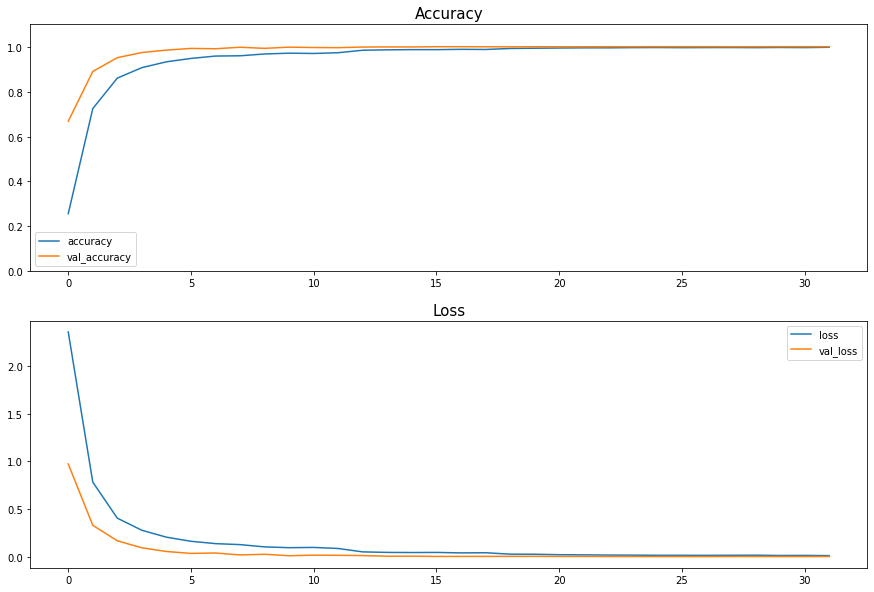

In [26]:
fig, axes = plt.subplots(2, 1, figsize=(15, 10))
ax = axes.flat

pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot(ax=ax[0])
ax[0].set_title("Accuracy", fontsize = 15)
ax[0].set_ylim(0,1.1)

pd.DataFrame(history.history)[['loss','val_loss']].plot(ax=ax[1])
ax[1].set_title("Loss", fontsize = 15)
plt.show()


In [27]:
# # Predict the label of the test_images
# pred = model.predict(X_test)
# pred = np.argmax(pred,axis=1)

# # Get the accuracy score
# acc = accuracy_score(y_test,pred)

# # Display the results
# printmd(f'## {acc*100:.2f}% accuracy on the test set')

y_test = np.array(test['label'])
X_test = np.array(test.drop(columns='label'))

y_test = pd.get_dummies(y_test)
X_test = pd.DataFrame(X_test).values.reshape(X_test.shape[0] ,28, 28, 1)

# X_test_flow = generator.flow(X_test, y_test, batch_size=32)
# X_test.shape,X_train.shape

y_test = pd.get_dummies(y_test)

In [28]:
# # Predict the label of the test_images
# pred = model.predict(X_test)
# pred = np.argmax(pred,axis=1)


# # # Get the accuracy score
# acc = accuracy_score(y_test,pred)

# # # Display the results
# print(f'## {acc*100:.2f}% accuracy on the test set')

In [29]:
from sklearn.metrics import classification_report

# predict 
pred = model.predict(X_test)
# pred = np.argmax(, axis=1)
# label
# y_train = np.argmax(y_train, axis=1)

# print(y_train.shape, pred.shape)
# print(y_train[:5], pred[:5])
y_pred = np.argmax(pred,axis=1)
y_test = np.argmax(y_test.values,axis=1)


In [30]:
# y_test

accuracy_score(y_test,y_pred)
# confusion_matrix(y_test,y_pred)

0.9807585052983826